In [ ]:
# | hide
import nbdev
from nbdev.showdoc import *

nbdev.nbdev_export()

# Tidy Tensors


In [ ]:
# | default_exp tensor

In [ ]:
# | export
import numpy as np

In [ ]:
# | exporti
def calculate_target_shape(s1, s2):
    """Calculate the target shape for broadcasting two tensors"""

    # expand shaped to be the same length. Note (1,) * <negative> is empty
    s2 = (1,) * (len(s1) - len(s2)) + s2
    s1 = (1,) * (len(s2) - len(s1)) + s1

    out_shape = ()
    for dims in list(zip(reversed(s1), reversed(s2))):
        if dims[0] != 1 and dims[1] != 1 and dims[0] != dims[1]:
            raise ValueError(f"Cannot broadcast {s1} and {s2}")
        out_shape = (max(dims),) + out_shape

    return out_shape

In [ ]:
# | exporti


def maybe_broadcast_elementwise(a, b):
    """Broadcast two tensors if they have different shapes"""
    if a.data.shape != b.data.shape:
        target_shape = calculate_target_shape(a.data.shape, b.data.shape)
        # print(
        #     f"Elementwise broadcasted {a.data.shape} and {b.data.shape} to {target_shape}"
        # )
        a = a.broadcast(target_shape)
        b = b.broadcast(target_shape)

    return a, b


def maybe_broadcast_matmul(a, b):
    """Broadcast two tensors if they have different shapes, except for the last two dimensions"""

    a_short_shape = a.data.shape[:-2]
    b_short_shape = b.data.shape[:-2]

    if a_short_shape != b_short_shape:
        target_shape = calculate_target_shape(a_short_shape, b_short_shape)
        print(
            f"Matmul broadcasted {a.data.shape} and {b.data.shape} to {target_shape + a.data.shape[-2:]}"
        )
        a = a.broadcast(target_shape + a.data.shape[-2:])
        b = b.broadcast(target_shape + b.data.shape[-2:])

    return a, b

In [ ]:
# | export


class Tensor:
    op = "L"
    name: str = ""
    parents: list = []

    def __init__(self, data, name=""):
        self.data = data
        self.name = name
        self.grad = np.zeros_like(self.data)

    def broadcast(self, target_shape):
        self_shape = self.data.shape
        if self_shape == target_shape:
            return self

        if len(self_shape) < len(target_shape):
            expanded_shape = (len(target_shape) - len(self_shape)) * (1,) + self_shape
        else:
            expanded_shape = self_shape

        final_shape = ()
        broadcasted_dims = ()

        for s_expanded, s_target in reversed(list(zip(expanded_shape, target_shape))):
            if s_expanded != s_target:
                if s_expanded != 1:
                    raise ValueError(f"Cannot broadcast {self_shape} to {target_shape}")
                else:
                    broadcasted_dims = (True,) + broadcasted_dims
                    final_shape = (s_target,) + final_shape

            else:
                broadcasted_dims = (False,) + broadcasted_dims
                final_shape = (s_expanded,) + final_shape

        broadcasted_data = np.broadcast_to(self.data, final_shape)

        assert final_shape == broadcasted_data.shape

        out = BroadcastTensor(data=broadcasted_data, name=self.name + "_broadcasted")
        out.parents = [self]
        out.broadcasted_dims = broadcasted_dims
        return out

    # Elementwise operations
    def add(self, other, name="Noname"):
        a, b = maybe_broadcast_elementwise(self, other)

        out = AddTensor(data=a.data + b.data, name=name)
        out.parents = [a, b]
        return out

    def sub(self, other, name="Noname"):
        a, b = maybe_broadcast_elementwise(self, other)
        out = SubTensor(data=a.data - b.data, name=name)
        out.parents = [a, b]
        return out

    def neg(self, name="Noname"):
        zero_tensor = Tensor(data=np.zeros_like(self.data), name="zero")
        out = zero_tensor.sub(self, name)
        out.parents = [zero_tensor, self]
        return out

    def mul(self, other, name="Noname"):
        a, b = maybe_broadcast_elementwise(self, other)
        out = MulTensor(data=a.data * b.data, name=name)
        out.parents = [a, b]
        return out

    def log(self, name="Noname"):
        out = LogTensor(data=np.log(self.data), name=name)
        out.parents = [self]
        return out

    def sigmoid(self, name="Noname"):
        out = SigmoidTensor(data=1 / (1 + np.exp(-self.data)), name=name)
        out.parents = [self]
        return out

    def relu(self, name="Noname"):
        out = ReluTensor(data=np.maximum(0, self.data), name=name)
        out.parents = [self]
        return out

    # Matrix operations
    def mmul(self, other, name="Noname"):
        a, b = maybe_broadcast_matmul(self, other)
        # a, b = self, other
        out = MatMulTensor(data=np.matmul(a.data, b.data), name=name)
        out.parents = [a, b]
        return out

    # Reduction operations
    def sum(self, name="Noname"):
        out = SumTensor(data=self.data.sum(), name=name)
        out.parents = [self]
        return out

    def backward(self):
        # Create a list of all parent nodes, in reverse order
        # Start with the current node
        visited = []
        nodes = []

        def walk(node):
            for p in node.parents:
                if p not in visited:
                    visited.append(p)
                    walk(p)
                    nodes.append(p)

        walk(self)
        nodes.append(self)

        # print(nodes)
        self.grad = np.ones_like(self.data)
        for n in nodes[::-1]:
            if hasattr(n, "_backward"):
                n._backward()

    def __repr__(self):
        value_repr = repr(self.data)
        if "\n" in value_repr:
            res = f"\n{self.name}=\n{str(self.data)}\n{self.name}.grad=\n{str(self.grad)}"
        else:
            res = f"{self.name}={str(self.data)} {self.name}.grad={str(self.grad)}"

        if self.parents:
            res += (
                f" {self.name}.parents=[" + ",".join([p.name for p in self.parents]) + "]"
            )

        return f"Tensor(shape=[{self.data.shape}])] op={self.op or ''} {res}"


class AddTensor(Tensor):
    op = "+"

    def _backward(self):
        self.parents[0].grad += self.grad
        self.parents[1].grad += self.grad


class SubTensor(Tensor):
    op = "-"

    def _backward(self):
        self.parents[0].grad += self.grad
        self.parents[1].grad -= self.grad


class MulTensor(Tensor):
    op = "*"

    def _backward(self):
        self.parents[0].grad += self.grad * self.parents[1].data
        self.parents[1].grad += self.grad * self.parents[0].data


class MatMulTensor(Tensor):
    op = "@"

    def _backward(self):
        # print(self.grad)
        self.parents[0].grad += np.matmul(self.grad, self.parents[1].data.T)
        self.parents[1].grad += np.matmul(self.parents[0].data.T, self.grad)


class SumTensor(Tensor):
    op = "sum"

    def _backward(self):
        self.parents[0].grad += self.grad


class SigmoidTensor(Tensor):
    op = "sigmoid"

    def _backward(self):
        self.parents[0].grad += self.grad * self.data * (1 - self.data)


class ReluTensor(Tensor):
    op = "relu"

    def _backward(self):
        self.parents[0].grad += self.grad * (self.data > 0)


class LogTensor(Tensor):
    op = "log"

    def _backward(self):
        self.parents[0].grad += self.grad * (1 / self.data)


class BroadcastTensor(Tensor):
    op = "broadcast"

    def _backward(self):
        axis = tuple([i for i, dim in enumerate(self.broadcasted_dims) if dim])
        summed = self.grad.sum(axis=axis, keepdims=True)

        if summed.shape != self.parents[0].data.shape:
            summed = summed.reshape(self.parents[0].data.shape)

        self.parents[0].grad += summed

In [ ]:
from fastcore.test import test_eq, test_fail

In [ ]:
test_eq(calculate_target_shape((1, 2, 3), (2, 3)), (1, 2, 3))
test_eq(calculate_target_shape((1, 2, 3), (2, 1)), (1, 2, 3))
test_eq(calculate_target_shape((1, 2, 3), (1, 3)), (1, 2, 3))
test_eq(calculate_target_shape((1, 2, 3), (1, 1)), (1, 2, 3))

test_eq(calculate_target_shape((1, 5), (3, 1)), (3, 5))

test_fail(calculate_target_shape, args=((1, 2, 3), (2, 2)), contains="Cannot broadcast")

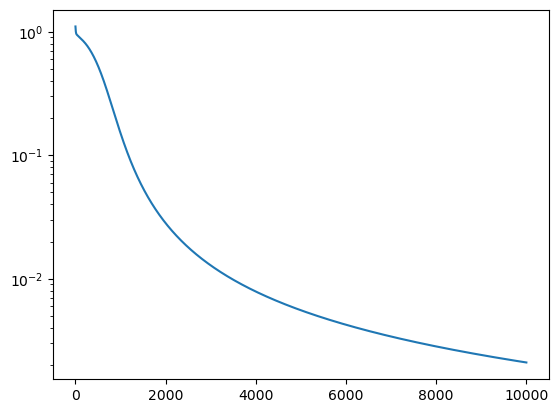

In [ ]:
import matplotlib.pyplot as plt

In [ ]:

X = [
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1],
]


Y = [0, 1, 1, 0]


np.random.seed(1337)

w1 = Tensor(np.random.randn(2, 6), "w1")
b1 = Tensor(np.zeros((1, 6)), "b1")

w2 = Tensor(np.random.randn(6, 1), "w2")

LR = 0.1

losses = []


def NN(x, y, w1, b1, w2):
    z1 = x.mmul(w1, "z1").add(b1, "z1").sigmoid("z1")
    preds = z1.mmul(w2, "z2").sigmoid("preds")

    diff = preds.sub(y, "diff")

    l = diff.mul(diff, "l")
    loss = l.sum("loss")

    return loss, (diff, preds)


for i in range(10000):
    x = Tensor(np.array(X, dtype=float), "x")
    y = Tensor(np.array(Y, dtype=float)[:, None], "y")

    loss, debug_outs = NN(x, y, w1, b1, w2)

    loss.backward()

    w1.data -= LR * w1.grad
    b1.data -= LR * b1.grad
    w2.data -= LR * w2.grad

    w1.grad = np.zeros_like(w1.grad)
    b1.grad = np.zeros_like(b1.grad)
    w2.grad = np.zeros_like(w2.grad)

    losses.append(loss.data)

plt.plot(losses)
plt.yscale("log")

In [ ]:
test_eq(loss.data < 0.1, True)

In [ ]:
from tidygrad.utils import grad_check

In [ ]:
w1 = Tensor(np.random.randn(2, 3) * 0.1, "w1")
b1 = Tensor(np.ones((1, 3)) * 0.01, "b1")

w2 = Tensor(np.random.randn(3, 1) * 0.1, "w2")

x = Tensor(np.array(X, dtype=float), "x")
y = Tensor(np.array(Y, dtype=float)[:, None], "y")

# z1 = Tensor(np.random.randn(4, 3), "fake_z1")


def NN(x, y, params, debug=list()):
    w1, b1, w2 = params
    a1 = x.mmul(w1, "z1").add(b1, "a1")

    z1 = a1.relu("z1")

    preds = z1.mmul(w2, "z2").sigmoid("preds")
    diff = preds.sub(y, "diff")
    l = diff.mul(diff, "l")

    loss = l.sum("loss")
    debug.append((a1, z1, preds, diff, l, loss))

    return loss


debug = []

loss = NN(x, y, (w1, b1, w2), debug)
loss.backward()

print(b1, *debug)

grad_check(NN, x, y, [w1, b1, w2])

Tensor(shape=[(1, 3)])] op=L b1=[[0.01 0.01 0.01]] b1.grad=[[0.00047515 0.00301901 0.00370138]] (Tensor(shape=[(4, 3)])] op=+ 
a1=
[[ 0.01        0.01        0.01      ]
 [ 0.10782226 -0.11173721 -0.12293954]
 [ 0.00985453 -0.12146527 -0.02796117]
 [ 0.10767679 -0.24320248 -0.16090072]]
a1.grad=
[[ 0.03165451  0.00301901  0.00370138]
 [-0.03141306  0.          0.        ]
 [-0.03161054  0.          0.        ]
 [ 0.03184424  0.          0.        ]] a1.parents=[z1,b1_broadcasted], Tensor(shape=[(4, 3)])] op=relu 
z1=
[[0.01       0.01       0.01      ]
 [0.10782226 0.         0.        ]
 [0.00985453 0.         0.        ]
 [0.10767679 0.         0.        ]]
z1.grad=
[[ 0.03165451  0.00301901  0.00370138]
 [-0.03141306 -0.00299598 -0.00367315]
 [-0.03161054 -0.00301481 -0.00369624]
 [ 0.03184424  0.0030371   0.00372356]] z1.parents=[a1], Tensor(shape=[(4, 1)])] op=sigmoid 
preds=
[[0.50038345]
 [0.50341039]
 [0.5003117 ]
 [0.50340579]]
preds.grad=
[[ 1.00076691]
 [-0.99317921]
 [-0.99

In [ ]:
# Relu check
t1 = Tensor(np.random.randn(10, 10), "t1")
b1 = Tensor(np.random.randn(10, 10), "b1")


def test(_x, _y, params):
    t1, b1 = params
    t2 = t1.add(b1).relu("t2")

    l = t2.sum("l")

    return l


l = test(None, None, (t1, b1))
l.backward()

grad_check(test, None, None, (t1, b1))

In [ ]:
import os
import numpy as np
import requests
from lovely_numpy import Lo

In [ ]:

def download_file(url, path):
    dir_path = os.path.dirname(path)

    os.makedirs(dir_path, exist_ok=True)
    if not os.path.exists(path):
        response = requests.get(url)
        with open(path, "wb") as f:
            f.write(response.content)


def load_mnist(path="../datasets/d/d/ddd/"):
    download_file(
        "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz",
        os.path.join(path, "mnist.npz"),
    )
    with np.load(os.path.join(path, "mnist.npz")) as f:
        x_train, y_train = f["x_train"], f["y_train"]
        x_test, y_test = f["x_test"], f["y_test"]
    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = load_mnist()

tt = Lo(x_train[0] / 255).chans(scale=10)

In [ ]:
LR = 0.1
BS = 32

INT_DIM = 128


w1 = Tensor(np.random.randn(784, INT_DIM) * 1, "w1")
b1 = Tensor(np.ones((1, INT_DIM)) * 0.1, "b1")

w2 = Tensor(np.random.randn(INT_DIM, 10) * 1, "w2")
# b2 = Tensor(np.zeros((1, 10)), "b2")


def MM(x, y, params, debug=list()):
    w1, b1, w2 = params
    z1 = x.mmul(w1, "z1").add(b1, "z1").sigmoid("z1")
    z2 = z1.mmul(w2, "z2").sigmoid("preds")

    # Let's try SE loss first
    diff = z2.sub(y, "diff")
    l = diff.mul(diff, "l")
    loss = l.sum("loss")

    # # loss = - sum[ y * log(p) + (1-y) * log(1-p) ]
    # #
    # ones = Tensor(np.ones_like(z2.data), "ones")
    # loss_1 = y.mul(z2.log(), "loss_1")
    # loss_2 = ones.sub(y).mul( ones.sub(z2, "loss_2").log() )
    # loss = loss_1.add(loss_2, "loss").sum().neg("loss").mul(Tensor(np.array(1/(BS*100)), "bs"), "loss")

    debug.append((z1, z2, diff, l, loss))
    return loss


np.seterr(all="raise")


idxs = np.random.choice(len(x_train), BS, replace=False)
x = Tensor(x_train[idxs].reshape(BS, 28 * 28) / 255, "x")
y_np = y_train[idxs][:, None]
y_np = np.eye(10)[y_np.reshape(-1)]

y = Tensor(y_np.astype(float), "y")

# One-hot encoding y
debug = []

loss = MM(x, y, (w1, b1, w2), debug=[])
loss.backward()

# print(b1, *debug)
grad_check(MM, x, y, (w1, b1, w2))

In [ ]:
Lo(w1.grad)

array[784, 128] n=100352 (0.8Mb) x∈[-0.564, 0.447] μ=0.002 σ=0.047

137.35317345301678
28.995428075257717
23.0176849462972
23.006744070484025
23.004142176563228
22.99846631045236
22.006502690315365
22.00407859756161
22.002956443258032
22.002009969187146
21.999610034566764
20.01377948572398
20.007174119699997
20.005031695942584
20.00391560725061
20.003198936477574
20.002666209463868
20.002200914919186
20.001652583612582
20.000116610421415
18.02574977112441
18.011084122500577
18.007552877722787
18.005888967521702
18.004886122311547
18.004200657339375
18.003695796074325
18.003305111545707
18.002991910117306
18.002734036574513
18.002517216759248
18.00233178827191
18.00217095118348
18.00202976740006
18.001904556706595
18.00179251565488
18.00169146777214
18.00159969432046
18.001515816217314
18.001438709497624
18.00136744343055
18.001301234359268
18.001239410688434
18.001181385853574
18.00112663694972
18.001074687199434
18.00102509072861
18.00097741824819
18.0009312422098
18.000886119760477
18.000841571242397
18.000797050822456
18.000751903590167
18.000705299

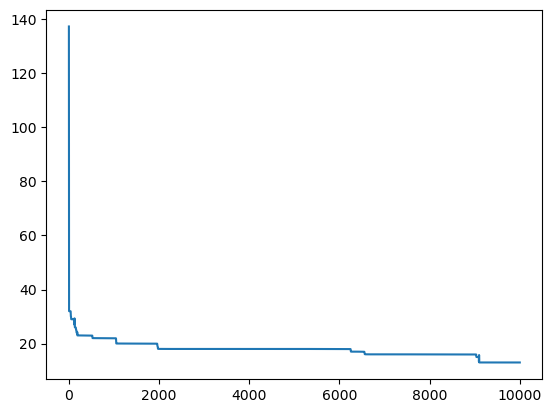

In [ ]:
#| eval: false

# over-fitting on 1 batch
idxs = np.random.choice(len(x_train), BS, replace=False)

losses = []

for i in range(10000):
    x = Tensor(x_train[idxs].reshape(BS, 28 * 28) / 255 - 0.5, "x")
    y_np = y_train[idxs][:, None]
    y_np = np.eye(10)[y_np.reshape(-1)]

    y = Tensor(y_np.astype(float), "y")

    # One-hot encoding y

    loss = MM(x, y, (w1, b1, w2))
    loss.backward()

    w1.data -= LR * w1.grad
    b1.data -= LR * b1.grad
    w2.data -= LR * w2.grad
    # b2.data -= LR * b2.grad

    w1.grad = np.zeros_like(w1.grad)
    b1.grad = np.zeros_like(b1.grad)
    w2.grad = np.zeros_like(w2.grad)
    # b2.grad = np.zeros_like(b2.grad)
    losses.append(loss.data)
    if i % 100 == 0:
        print(loss.data)

plt.plot(losses);
# plt.yscale("log")